## Overview

Provided dataset comes from an online store selling video games and has data for the past several decades, the table contains titles, platforms, years of release, genres, sales by region, user and critic scores, as well as maturity ratings. In the course of the project I'll analyze the market data to find the most popular regional platforms and games to compare platforms and video game genres by sales to define a product with the highest potential of becoming popular, thus that should advertise and sell well.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
games = pd.read_csv("/Datasets/Project05IntegratedProject01/games.csv")
print(games.head())

                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN  


In [2]:
print(games.info())
print()
print(games.isna().sum().sort_values(ascending = False))
print()
print(games.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None

Critic_Score       8578
Rating             6766
User_Score         6701
Year_of_Release     269
Genre                 2
Name                  2
Other_sales           0
JP_sales              0
EU_sales              0
NA_sales              0
Platform              0
dtype: int64

(16715, 11)


The starting dataset contains 16715 rows with 11 columns. 6 of the columns contain blank cells (NaN values):
- Critic_Score (8578)
- Rating (6766)
- User_Score  (6701)
- Year_of_Release (269)
- Name and Genre (2)  

I'll fill NA in Year of Release by the median if titles match, then I will find the most common release year by the platform. I'll also change data types in Year_of_Release, User_Score and to appropriate numerical ones. I will not fill the missing values in sales cause it should mean that the game was not selling in the region.

## Data Preprocessing

### Converting column names to lowercase letters

In [3]:
columns = games.columns.tolist()
columns_lowered = [word.lower() for word in columns]
games.columns = columns_lowered

In [4]:
print(games.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


### Filling NA in Year of Release

I decided to fill NAs with median values if titles match, cause some games are released on several platforms, so I assume that they were released in one of the years between the releases of the game on other platforms, and sometimes in the same year where there is information. Let's assume the game was released in 2010, 2013, 2013 and X on several platforms, then 2013 will get chosen, if there are only two known release dates, then one can assume it was released between them.

In [5]:
year = games.pivot_table(index = 'name', values = 'year_of_release', aggfunc='median') 
#to create a column which will find the appropriate year of release
year.columns = ['release_year'] #changing column name in the newly created pivot table
games = games.merge(year, on = 'name', how='left') #merging two tables by the name of the game from the main table
games['year_of_release'].fillna(games['release_year']) #filling NA values by the column of the merged table

0        2006.0
1        1985.0
2        2008.0
3        2009.0
4        1996.0
          ...  
16710    2016.0
16711    2006.0
16712    2016.0
16713    2003.0
16714    2016.0
Name: year_of_release, Length: 16715, dtype: float64

If the game wasn't released on several platforms, i.e. the previous method didn't fill the blanks, I filled them by the most active (or common) release year of the platform, firstly, cause consoles have a certain product life cycle, and secondly, the most active year will just remain the most active year and it should not skew the overall picture.

In [6]:
nan_platforms = games.loc[(games['year_of_release'].isna()), 'platform'].unique() 
print(nan_platforms) #choosing platforms with empty cells in 'year_of_release'
platform = games.pivot_table(index = 'platform', values = 'year_of_release', aggfunc=pd.Series.mode)
#finding the most common years, by making a new table
platforms_needed = platform.query('platform in @nan_platforms')
#selecting the needed platformst from the newly created pivot table
platforms_needed.columns = ['platform_mode_release']
#changing the table name to keep the new name by which I will be filling the blanks
print(platforms_needed)

games = games.merge(platforms_needed, on = 'platform', how='left') #merging the tables
games['year_of_release'] = games['year_of_release'].fillna(games['platform_mode_release'])
#filling na in the main table by the new one (mode of the year of release)

games.drop(columns='release_year', inplace = True)
games.drop(columns='platform_mode_release', inplace = True) #dropping odd columns created to merge

print(games.head())

['PS2' 'Wii' '2600' 'X360' 'GBA' 'PC' 'PS3' 'PS' 'PSP' 'XB' 'GB' 'DS' 'GC'
 '3DS' 'N64' 'PSV']
         platform_mode_release
platform                      
2600                      1981
3DS                       2011
DS                        2008
GB                        2000
GBA                       2002
GC                        2002
N64                       1999
PC                        2011
PS                        1998
PS2                       2002
PS3                       2011
PSP                       2006
PSV                       2015
Wii                       2009
X360                      2011
XB                        2003
                       name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Re

In [7]:
games['year_of_release'] = games['year_of_release'].astype('int') #switching type in 'year_of_release'
games['world_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
#counting global sales by summing up the amounts of regional ones
print(games)

                                name platform  year_of_release         genre  \
0                         Wii Sports      Wii             2006        Sports   
1                  Super Mario Bros.      NES             1985      Platform   
2                     Mario Kart Wii      Wii             2008        Racing   
3                  Wii Sports Resort      Wii             2009        Sports   
4           Pokemon Red/Pokemon Blue       GB             1996  Role-Playing   
...                              ...      ...              ...           ...   
16710  Samurai Warriors: Sanada Maru      PS3             2016        Action   
16711               LMA Manager 2007     X360             2006        Sports   
16712        Haitaka no Psychedelica      PSV             2016     Adventure   
16713               Spirits & Spells      GBA             2003      Platform   
16714            Winning Post 8 2016      PSV             2016    Simulation   

       na_sales  eu_sales  jp_sales  ot

In [8]:
games['user_score'] = games['user_score'].replace('tbd', np.nan) #switching 'tbd' in 'user_nan' column to NaN
games['user_score'] = games['user_score'].astype('float64') #switching type of 'user_score' to 'float64'

I suppose that "tbd" stands for 'to be determined', i.e. the score will be defined or counted in the future. In this case, these are not user scores and they're missing in fact, so I turned the values to NaN, I also switched the column type to 'float64', cause it accepts NaN values.

### Data Preprocessing Summary
I filled the 'year_of_release' and changed the type in the column to integers, I also changed 'tbd' to NaN in 'user_score' and changed the type to 'float64'. <br/> Didn't do anything with other columns cause filling such a huge number of NAs (almost a half), will negatively affect the overall picture, for example, will decrease or increase the importance of some consoles and genres, and games with age rating (M - Mature) may become "Everyone 10+" (E10), so it's not possible to fill it by rating, cause there are different games in one genre, so one may encounter racing games with cartoon like style and others that border with shooters, like Carmageddon, one wouldn't call it a game for kids.<br/>

<p>Those missing values in year of release must have appeared due to the people who were entering the data in the database.</p>

<p>I will assume that a lot of data is missing cause the games with missing data are unpopular, there's a lack of votes to calculate the user score (for example, if only two people voted for it), or in the same way too few critics or no one have rated it, or the games existed well before the implementation of ESRB. One more reason may be a different name of the game in two different tables (due to regional naming, or to a punctuation mark), so when one was merging the tables (scores and ESRB ratings) with the other (year of release, title, platform), a part of the data may have gone missing, or simply the game was only selling in one region. Again, I would not fill the missing values by rating of the game, cause scores may be different due to poor porting of the game to a different platform (like it's not as comfortable to play the ported game with a mouse as it is with a gamepad). 

## Exploratory Data Analysis
### See, how many games were released throughout the years. Are data for all periods important?

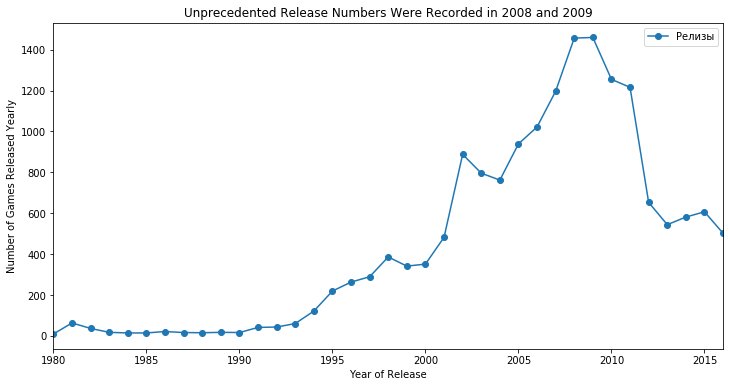

In [9]:
games_a_year = games.pivot_table(index = 'year_of_release', values = 'name', aggfunc='count')
games_a_year.columns = ['games_count']
games_a_year.plot(style='-o', figsize = (12, 6))
plt.title('Unprecedented Release Numbers Were Recorded in 2008 and 2009')
plt.xlabel('Year of Release')
plt.ylabel('Number of Games Released Yearly')
plt.legend(['Releases'])
plt.show()

Not all data are important, so my answer is 'no, it isn't' cause judging by the plot, the game industry  was showing relatively low activity in the period from 1980 to 1994, that's when the game industry was being born, then it started gradually growing until the leap in 2008, and it was falling down after 2009.

#### Sales throughout the years by platform. Choose platforms with the highest total sales and build a distribution graph by year. In which period of time a new platform goes out on the market and vanishes?

In [10]:
sales_year_platform = games.pivot_table(index = ('platform', 'year_of_release'), values = 'world_sales', aggfunc='sum').sort_values(by =['platform', 'world_sales'], ascending=True)
sales_year_platform.head()
#Video Game Sales by Platform and Year

world_sales
platform year_of_release             
2600     1984                    0.27
         1985                    0.45
         1989                    0.63
         1986                    0.67
         1988                    0.74

In [11]:
sales_by_platform = games.pivot_table(index = 'platform', values = 'world_sales', aggfunc='sum').sort_values(by =['platform', 'world_sales'], ascending='True')
sales_by_platform.head()
#sales during the existence of platform and before their 'disappearance' from the market

,world_sales
platform,
2600,96.98
3DO,0.10
3DS,259.00
DC,15.95
DS,806.12


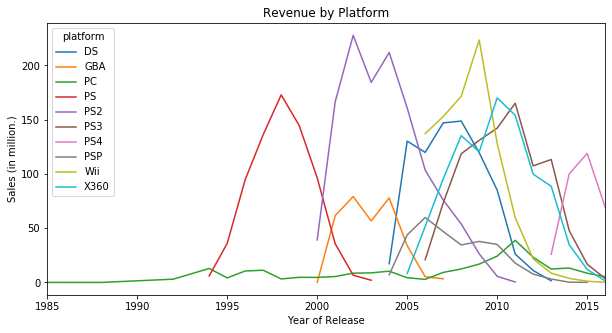

In [12]:
top_10_platforms = sales_by_platform.sort_values(by='world_sales', ascending = False).head(10)
#sorting top 10 platforms by descending of total sales during the whole period of game industry existence until 2016
top_10_platforms = top_10_platforms.index.values
#saving platform names
top_10_by_year = sales_year_platform.query('platform in @top_10_platforms')
#looking for top 10 platforms by total sales to find how many of those platform games were sold yearly
top_10_by_year = top_10_by_year.reset_index()
#reset index to create a new table
top_10_by_year = top_10_by_year.pivot(index='year_of_release', columns='platform', values='world_sales')
#transposing the table to build the plot
top_10_by_year.plot(figsize=(10,5))
plt.title('Revenue by Platform')
plt.xlabel('Year of Release')
plt.ylabel('Sales (in million.)')
plt.show()

One can see a product life cycle in sales, starting from its market entry to exit, cause new technologies emerge, the technologies that get to make a new console. A console exists 7-10 years prior to getting taken off the market, but the growth reaches its peak within the first 5 years. In general, consoles come and go, and PC remains. ;) PS4 there has probably "fallen" just cause the data for 2016 aren't full.

#### Select the data for the corresponding actual period. Define the actual period on your own as a result of previous research. The main factor — these data will help building the forecast for 2017.

In [13]:
present_games = games.query('year_of_release >= 2012') 

I chose the so called actual period to be since 2012, because, the era of PS2 has come to its end by 2011, so I will not be pulling the "tails", and the relatively modern consoles have stayed, that's why I consider the period of the last 5 years to be sufficient.

#### Which platforms lead the sales, which ones rise and fall? Select several potentially profitable platforms.

In [14]:
present_pivot = present_games.pivot_table(index = 'platform', 
                                          columns = 'year_of_release', 
                                          values = 'world_sales', 
                                          aggfunc = 'sum').fillna(0)
present_pivot.reset_index(inplace=True)
present_pivot['total_sales'] = present_pivot.iloc[:, 1:].sum(axis=1) #to count total sales
top_10_platforms = present_pivot.sort_values(by = 'total_sales', ascending = False)
print(top_10_platforms)
print()
print('Top 5 platforms leading the sales during the actual period:', top_10_platforms['platform'].head().tolist())

year_of_release platform    2012    2013    2014    2015   2016  total_sales
4                    PS4    0.00   25.99  100.00  118.90  69.25       314.14
3                    PS3  107.36  113.25   47.76   16.82   3.60       288.79
9                   X360   99.74   88.58   34.74   11.96   1.52       236.54
0                    3DS   51.36   56.57   43.76   27.78  15.14       194.61
10                  XOne    0.00   18.96   54.07   60.14  26.15       159.32
8                   WiiU   17.56   21.65   22.03   16.35   4.60        82.19
2                     PC   23.22   12.38   13.28    8.52   5.25        62.65
6                    PSV   16.19   10.59   11.90    6.51   4.25        49.44
7                    Wii   21.71    8.59    3.75    1.14   0.18        35.37
1                     DS   11.01    1.54    0.00    0.00   0.00        12.55
5                    PSP    7.69    3.14    0.24    0.12   0.00        11.19

Top 5 platforms leading the sales during the actual period: ['PS4', 'PS3', 

If one doesn't consider 2016 with its incomplete data, then PS4 and XOne are 'growing' as consoles of the last generation, as for the rest, the decrease is noticeable.

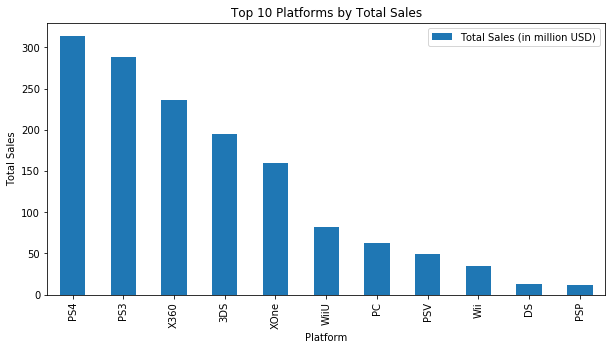

In [15]:
top_10_platforms.plot(x='platform', y='total_sales', kind='bar', figsize=(10,5))
plt.xlabel('Platform')
plt.ylabel('Total Sales')
plt.title('Top 10 Platforms by Total Sales')
plt.legend(['Total Sales (in million USD)'])
plt.show()

A bar chart for visibility, there is a sharp decline at WiiU after XOne, so I will limit the research by 5 platforms.

#### Build a boxplot to demonstrate the global sales of each game by platform. Is the difference in sales big? What about the average sales on different platforms? Describe the result.

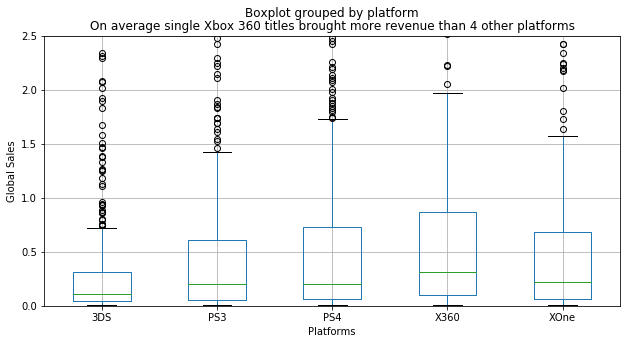

In [16]:
five_platforms = ['PS4', 'PS3', 'X360', '3DS', 'XOne']
selected_platforms = games[(games['platform'].isin(five_platforms)) & (games['year_of_release'] >= 2012)]
fig, ax = plt.subplots(figsize = (10,5))
bp = selected_platforms.boxplot(ax = ax, column = 'world_sales', by = 'platform')
ax.set_ylim(0, 2.5)
plt.title('On average single Xbox 360 titles brought more revenue than 4 other platforms')
plt.ylabel('Global Sales')
plt.xlabel('Platforms')
plt.show()

One can see how XBox 360 is distinguished among other platforms and even mean sales of XOne games are slightly higher than any PlayStation console. I would assume, that's because some games, that are selling for Xbox One and Xbox 360 are sold on Microsoft Store, i.e. these are cross-platform games (one can play them on PC as well) that one has access to on any of the platforms by making one purchase in an account. However by comparing PS4 and XOne, it's easy to notice that the upper quartile of PS4 is higher, so the relatively sucessful game released on PS4 is still being sold better than the one on XOne. Well, Nintendo 3DS is far behind its competitors, though it's a different kind of consoles with its own rather niche market, which explains its low sales in comparison to the other 4 platforms.

#### See how user and critic scores affect sales within one platform. Build a scatter plot and calculate the correlation between scores and sales. Conclude.

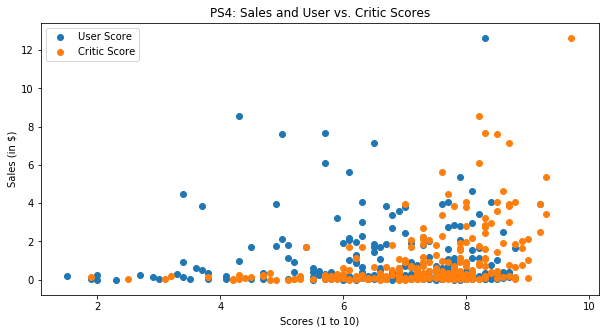

In [17]:
PS4 = games[(games['platform'] == 'PS4') & (games['year_of_release'] >= 2012)]
#PS4.plot(x = 'user_score', y = 'world_sales', kind = 'scatter')
fig, ax = plt.subplots(figsize = (10,5))
plt.scatter(PS4['user_score'], PS4['world_sales'])
plt.scatter(PS4['critic_score'] / 10, PS4['world_sales']) #divided critic_score by 10 to normalize it with user_score
plt.title('PS4: Sales and User vs. Critic Scores')
plt.ylabel('Sales (in $)')
plt.xlabel('Scores (1 to 10)')
plt.legend(['User Score', 'Critic Score'])
plt.show()

I'm most interested in PS4 cause I own one. There seems to be a correlation between critic scores and sales, but it isn't obvious at all when it comes to correlation between user scores and sales.

In [18]:
print("User Score Correlation with Sales: {:.2f}".format(PS4['user_score'].corr(PS4['world_sales'])))
print("Critic Score Corerelation with Sales: {:.2f}".format(PS4['critic_score'].corr(PS4['world_sales'])))

User Score Correlation with Sales: -0.03
Critic Score Corerelation with Sales: 0.41


Now it's obvious that there is no correlation between user sales and ratings, yet critics, apparently, appear to be more objective in their judgements, as one can observe a positive correlation of 41%, one could even tell that it's a high correlation if he or she takes into consideration that a purchase depends on human behaviour.

#### Match your findings with game sales on other platforms.

There was another thing that stood out in the boxplot, despite only the average high sales value on XBox One, outliers (anomalous observations) for PS4 and 3DS sales are more densely concentrated above the third quantiles, and XBox One game sales turned out to be lower than the first year already in 2015, however, 3DS sales too, but the 3DS video games total sales are even higher than sales of video games released on Xbox One. I think developers should take a chance with a PS4  project in 2017. The XBox 360 and PS3 have almost lost their relevance by 2015.

#### Look at the general game distribution by genre. What can one say about the most profitable genres? Do they stand out with high and low sales?

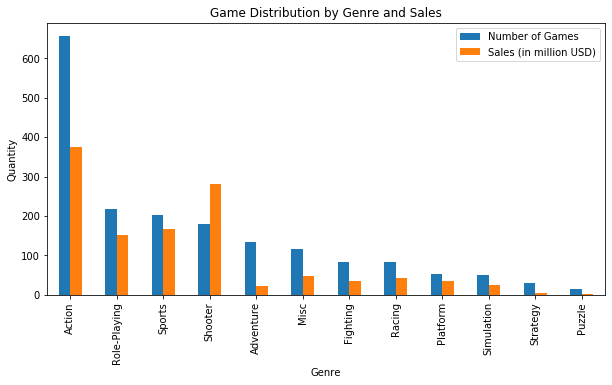

In [19]:
selected_by_genre = selected_platforms.pivot_table(index = 'genre', 
                                                             values = 'world_sales', 
                                                             aggfunc = {'count', 'sum'}).sort_values(by='count', ascending = False)
selected_by_genre.plot(kind='bar', figsize = (10,5))
plt.title('Game Distribution by Genre and Sales')
plt.ylabel('Quantity')
plt.xlabel('Genre')
plt.legend(['Number of Games', 'Sales (in million USD)'])
plt.show()

Most of the games come out in the Action genre, but on average they pay less than Shooters, while there are almost three times less Shooters than Action games. Best-selling genres: Action, RPG, Sports and Shooters. Worst selling genres: Adventure, Strategy, Puzzle.

## Creating a user profile for each region

### Top 5 Popular Platforms. Describe the differences in sales ratio.

In [20]:
na_top_platforms = present_games.pivot_table(index='platform', 
                                             values = ('na_sales', 'world_sales'), 
                                             aggfunc = 'sum').sort_values(by='na_sales', ascending = False)
na_top_platforms['na_world_ratio'] = na_top_platforms['na_sales'] / na_top_platforms['world_sales']
na_top_five = na_top_platforms.head()

print(na_top_five)

          na_sales  world_sales  na_world_ratio
platform                                       
X360        140.05       236.54        0.592077
PS4         108.74       314.14        0.346151
PS3         103.38       288.79        0.357976
XOne         93.12       159.32        0.584484
3DS          55.31       194.61        0.284209


In addition, I calculated the share of total sales of the games released on these platforms in North America, and did the same for other regions, but I've only displayed it as percentages in pie-charts.

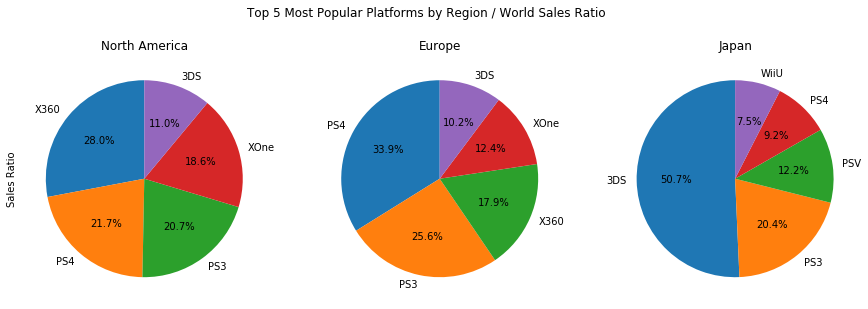

In [21]:
eu_top_platforms = present_games.pivot_table(index='platform', 
                                             values = ('eu_sales', 'world_sales'), 
                                             aggfunc = 'sum').sort_values(by='eu_sales', ascending = False)
eu_top_platforms['eu_world_ratio'] = eu_top_platforms['eu_sales'] / eu_top_platforms['world_sales']
eu_top_five = eu_top_platforms.head()


jp_top_platforms = present_games.pivot_table(index='platform', 
                                             values = ('jp_sales', 'world_sales'), 
                                             aggfunc = 'sum').sort_values(by='jp_sales', ascending = False)
jp_top_platforms['jp_world_ratio'] = jp_top_platforms['jp_sales'] / jp_top_platforms['world_sales']
jp_top_five = jp_top_platforms.head()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle('Top 5 Most Popular Platforms by Region / World Sales Ratio')
na_top_five['na_sales'].plot(kind='pie',autopct='%1.1f%%', ax=axes[0], startangle=90, 
                                   title='North America', label ='Sales Ratio')
eu_top_five['eu_sales'].plot(kind='pie',autopct='%1.1f%%', ax=axes[1], startangle=90, 
                                   title='Europe', label ='')
jp_top_five['jp_sales'].plot(kind='pie',autopct='%1.1f%%', ax=axes[2], startangle=90, 
                                   title='Japan', label ='')
plt.show()

Top 5 Popular Platforms in **North America** (in descending order): <br/>
X360, PS4, PS3, XOne, 3DS <br/>
Top 5 Popular Platforms in **Europe**: <br/>
PS4, PS3, X360, XOne, 3DS <br/>
Top 5 Popular Platforms in **Japan**: <br/>
3DS, PS3, PSV, PS4, WiiU <br/>
<br />
The main console of the previous generation (prior to XOne/PS4) in North America was X360, that's why it's surprising that PS4 (21.7%) has outrun XOne (18.6%), though the gap isn't large. One can recognize the main console of the generation by looking at Europe, where PS4 took 1/3 of the total regional sales and XOne games are almost 3 times less popular (33.9% vs 12.4%, accordingly), PS has been leading the market for a long time. Perhaps, Japan's preferences turned out to be the most unexpected ones, Nintendo dominates its home market with 3DS (50.7%) and WiiU(7.5%), top 5 platforms don't include XBox and the gap is even more sensible if one pays attention to 3DS being an unpopular platform in other regions other than Japan.

### Most Popular Genres (Top-5)

In [22]:
na_top_genres = present_games.pivot_table(index='genre', 
                                             values = ('na_sales', 'world_sales'), 
                                             aggfunc = 'sum').sort_values(by='na_sales', ascending = False)
na_top_genres['na_world_ratio'] = na_top_genres['na_sales'] / na_top_genres['world_sales']
na_top_five = na_top_genres.head()
print(na_top_five)

              na_sales  world_sales  na_world_ratio
genre                                              
Action          177.84       441.12        0.403156
Shooter         144.77       304.73        0.475076
Sports           81.53       181.07        0.450268
Role-Playing     64.11       193.06        0.332073
Misc             38.19        85.04        0.449083


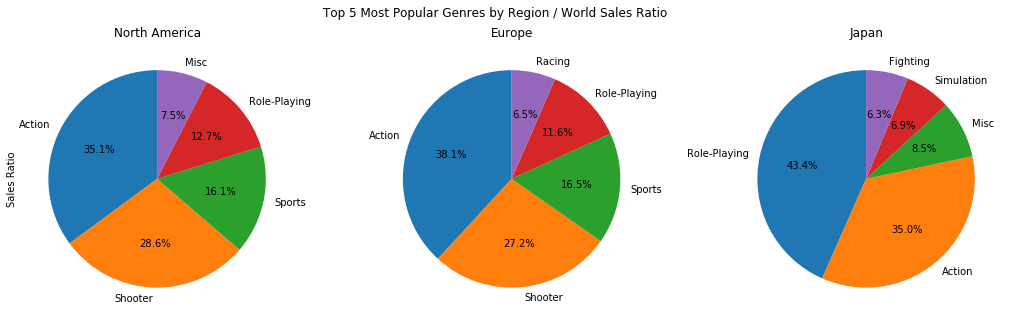

In [23]:
eu_top_genres = present_games.pivot_table(index='genre', 
                                             values = ('eu_sales', 'world_sales'), 
                                             aggfunc = 'sum').sort_values(by='eu_sales', ascending = False)
eu_top_genres['eu_world_ratio'] = eu_top_genres['eu_sales'] / eu_top_genres['world_sales']
eu_top_five = eu_top_genres.head()


jp_top_genres = present_games.pivot_table(index='genre', 
                                             values = ('jp_sales', 'world_sales'), 
                                             aggfunc = 'sum').sort_values(by='jp_sales', ascending = False)
jp_top_genres['jp_world_ratio'] = jp_top_genres['jp_sales'] / jp_top_genres['world_sales']
jp_top_five = jp_top_genres.head()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,5))
fig.suptitle('Top 5 Most Popular Genres by Region / World Sales Ratio')
na_top_five['na_sales'].plot(kind='pie',autopct='%1.1f%%', ax=axes[0], startangle=90, 
                                   title='North America', label ='Sales Ratio')
eu_top_five['eu_sales'].plot(kind='pie',autopct='%1.1f%%', ax=axes[1], startangle=90, 
                                   title='Europe', label = '')
jp_top_five['jp_sales'].plot(kind='pie',autopct='%1.1f%%', ax=axes[2], startangle=90, 
                                   title='Japan', label = '')
plt.show()

Top 5 Popular Genres in **North America** (in descending order): <br/>
Action, Shooter, Sports, Role-Playing, Miscellaneous <br/>
Top 5 Popular Genres in **Europe**: <br/>
Action, Shooter, Sports, Role-Playing, Racing <br/>
Top 5 Popular Genres in **Japan**: <br/>
Role-Playing, Action, Misc, Simulation, Fighting <br/>
<br />
The genres in North America and Europe have roughly the same distribution, with the only difference that Europeans are more defined in their tastes, because they like racing more than miscellaneous genres. Japan is different again, perhaps due to the existence of a separate jRPG genre, in general, the RPG genre took first place with 43.4%, but Action in Japan is even more loved than in North America and Europe (35% versus 28.6% and 27.2%).

### Does ESRB rating influence sales in particular regions?

The ratio between total sales and the number of games, according to the age category by rating in the ratio column.

In [24]:
esrb_na = present_games.groupby('rating')['na_sales'].agg(['count', 'sum'])
esrb_na['ratio'] = esrb_na['sum'] / esrb_na['count']
print(esrb_na.sort_values(by = 'ratio', ascending = True))

        count     sum     ratio
rating                         
T         413   66.13  0.160121
E10+      306   75.70  0.247386
E         395  114.37  0.289544
M         498  231.57  0.465000


In [25]:
esrb_eu = present_games.groupby('rating')['eu_sales'].agg(['count', 'sum'])
esrb_eu['ratio'] = esrb_eu['sum'] / esrb_eu['count']
print(esrb_eu.sort_values(by = 'ratio', ascending = True))

        count     sum     ratio
rating                         
T         413   53.01  0.128354
E10+      306   55.37  0.180948
E         395  113.03  0.286152
M         498  193.96  0.389478


The relationship between ESRB rating and sales is noticeable, as the ratio increases when reaching a larger audience from "teens" to "everyone", but games with more violent content bring in more money, since "mature" includes the most paying, working audience. It is interesting that in North America they pay more for such content than in Europe (0.465 versus 0.389), apparently the average age of a gamer is higher there.

In [26]:
esrb_jp = present_games.groupby('rating')['jp_sales'].agg(['count', 'sum'])
esrb_jp['ratio'] = esrb_jp['sum'] / esrb_jp['count']
print(esrb_jp.sort_values(by = 'ratio', ascending = True))

        count    sum     ratio
rating                        
E10+      306   8.19  0.026765
M         498  21.20  0.042570
T         413  26.09  0.063172
E         395  28.33  0.071722


According to the results, in Japan, adults (M) and children (E10 +) play less than teenagers, which generally agrees with the former findings where shooters didn't enter the top 5 genres in Japan (assuming that shooters are conventionally included in mature category "M"), and the Japanese are more sensitive to the difference between E and E10+. <br/> The ESRB rating affects sales in certain regions, it most likely depends on the number of consumers in different age groups and their preferences.

## Hypothesis testing

### Mean user scores on XBox One and PC are the same;
H<sub>0</sub>: μ<sub>1</sub> - μ<sub>2</sub> = 0 <br/>
H<sub>A</sub>: μ<sub>1</sub> - μ<sub>2</sub> ≠ 0 <br/>

In order to compare mean user scores of video games released on 2 platforms (XOne and PC), I'll need Welch's t-test with equal_var=False cause the 2 sample sizes are different (188 and 206 observations, correspondingly)

In [27]:
XOne = present_games.query('platform == "XOne"')
PC = present_games.query('platform == "PC"')
XOne = XOne[XOne.user_score.notnull()] #188 non-null lines
PC = PC[PC.user_score.notnull()] #206 non-null lines

import scipy.stats as st

alpha = .05
results = st.ttest_ind(XOne['user_score'], PC['user_score'], equal_var = False)

print('p-value:', results.pvalue.astype('float64'))
if (results.pvalue < alpha):
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

p-value: 0.5489537965134912
Fail to reject the null hypothesis


p-value is higher than any standard significance level, I failed to reject the null hypothesis, according to which user scores on two platforms are the same, and cannot accept the alternative one.

### Mean user scores of action and sports genres are different.
H<sub>0</sub>: μ<sub>1</sub> - μ<sub>2</sub> = 0 <br/>
H<sub>A</sub>: μ<sub>1</sub> - μ<sub>2</sub> ≠ 0 
<p>In order to compare video games mean user scores of 2 different genres, I set equal_var = False in Welch's t-test, cause the sample sizes are different (n<sub>Action</sub> = 523, n<sub>Sports</sub> = 195).</p>

In [28]:
Action = present_games.query('genre == "Action"')
Sports = present_games.query('genre == "Sports"')
Action = Action[Action.user_score.notnull()] #523 non-null lines
Sports = Sports[Sports.user_score.notnull()] #195 non-null lines

alpha = .05
results = st.ttest_ind(Action['user_score'], Sports['user_score'], equal_var = False)

print('p-value:', results.pvalue.astype('float64'))
if (results.pvalue < alpha):
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

p-value: 4.24307776572644e-20
Reject the null hypothesis


p-value is infinitesimal and lower than any standard significance level, the null hypothesis should be rejected and the alternative hypothesis accepted. According to the alternative hypothesis, mean user scores are different.

In [29]:
print(Action['user_score'].mean())
print(Sports['user_score'].mean())

6.825047801147237
5.455897435897437


Action mean user scores are higher than Sports.

## Conclusion

An analysis of video game market was conducted, where I selected the actual period since 2012 in order to include the number of the relatively latest consoles. Unfortunately, not all scores were available for a more precise and profound analysis, but if my assumption on insufficient popularity of those games with empty cells in scores is right, then one could consider the sample with available data as representative. It would be best to use the database of metacritic.com. SMM specialists of the online store should focus on advertising Action, Shooters and Sports (their market reach is estimated to 81.8% (38.1% + 27.2% + 16.5%) among top 5 genres and recognize mature age group (ESRB: M) of PS4 users, especially cause XOne and 3DS are losing popularity in Europe, where XOne is three times less popular than PS4, but if it's a cross-platform game, then it will sell on both consoles, as the average console scores are similar, one could also consider critic scores since a positive correlation with sales of 41% was observed to select the important action games to advertise and sell on the store, as their sales aren't as high as shooters in proportion.